In [2]:
import re 
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence, unpack_sequence, PackedSequence, pad_sequence
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datetime
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import importlib

In [3]:
def elu1(x):
    return F.elu(x, inplace=True) + 1.

class Elu1(nn.Module):
    """
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:

    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x):
        return elu1(x)

In [4]:
class LinearReadout(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
        
    def forward(self, x):
        x = self.linear(x)
        return x.squeeze(dim=2)

In [5]:
class NonlinearDecoder(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, dropout=0.0, device=None):
        super().__init__()
        
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.device = device
        
    def forward(self, factors):
        # concatenate all sequences, forward into linear layer and split again
        lengths = [factor.shape[0] for factor in factors]
        cat_fs = torch.cat(factors, dim=0)
      #  cat_fs = self.dropout(cat_fs)
        rates = self.linear(cat_fs)
        rates = [rate for rate in torch.split(rates, lengths)]
        
        return rates
    
    
class LinearReadout(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.linear(x)
        #return x.squeeze(dim=2)
        return x

In [6]:
class CoreAndReadout(nn.Module):
    def __init__(self, core, readout, nonlinearity=None):
        super().__init__()
        self.core = core
        self.readout = readout
        self.nonlinearity = elu1 if nonlinearity is None else nonlinearity
        
    def forward(self, x):
        x = self.core(x)
        x = self.readout(x)
        return x

In [7]:
def get_device(cpu_preference=False, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() and not cpu_preference else "cpu")
    if verbose: print("Using device:", device)
    return device

In [8]:
def create_lineplots(all_probs_array, y_val, y_labels, trial, shift, n_epochs, hidden_size, file_path, features, size=(18, 5), show_plot=True):
    # Create a figure with subplots for each variable
    fig, axs = plt.subplots(len(y_labels), 1, figsize=size, linewidth=0.01)
    
    if len(y_labels) == 1:
        axs = [axs]  # Wrap the single Axes object in a list   
    
    for i, label in enumerate(y_labels):
        ax = axs[i]
        ax.plot(y_val[:, i], label='True', linewidth=2.5, color='blue')  # True values in blue
        ax.plot(all_probs_array[:, i], label='Predicted', linewidth=2.5, color='orange')  # Predicted values in orange

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'(dyadic model) (val trial: {trial}, lag: {shift}, epochs: {n_epochs}, hidden states: {hidden_size})')
            ax.legend()
        
        ax.set_xlabel('Time Step',labelpad=0.5)
        ax.set_ylabel(label)
        feature_names = ", ".join(features)
        fig.text(.5, .00001, f"Features: {feature_names}", ha='center', fontsize=14)
        
        if file_path is not None:
            plt.savefig(file_path)

    # Show the plots if requested
    if show_plot:
        plt.tight_layout()  # Adjust spacing between subplots for better layout
        plt.show()

In [9]:
class M2S_Loss2(nn.Module):
    def __init__(self, criterion=None):
        super().__init__()
        self.criterion = criterion if criterion is not None else nn.MSELoss(reduction='sum')
        
    def forward(self, y_pred, y):
        # Ensure y_pred and y are lists of sequences
        if isinstance(y_pred, list) and isinstance(y, list):
            # Pad sequences to ensure they have the same length
            padded_y_pred = pad_sequence([seq for seq in y_pred], batch_first=True)
            padded_y = pad_sequence([seq for seq in y], batch_first=True)
            
            # Move to the same device
            device = padded_y_pred.device
            padded_y = padded_y.to(device)
            
            # Create a mask to ignore padding tokens
            mask = (padded_y != 0).float()
            
            # Compute the loss (MSE in this case) between the padded sequences
            loss = self.criterion(padded_y_pred * mask, padded_y * mask)
            return loss
        else:
            raise ValueError('y_pred and y should be lists of sequences.')

In [10]:
class M2S_Loss3(nn.Module):
    def __init__(self, criterion=None):
        super().__init__()
        # Default criterion is MSELoss with mean reduction
        self.criterion = criterion if criterion is not None else nn.MSELoss(reduction='mean')
        
    def forward(self, y_pred, y):
        # Ensure y_pred and y are lists of sequences
        if isinstance(y_pred, list) and isinstance(y, list):
            total_loss = 0
            total_valid_sequences = 0
            
            for i in range(len(y_pred)):
                pred_seq = y_pred[i]
                target_seq = y[i]

                # Ensure both sequences have the same length
                valid_length = min(pred_seq.shape[0], target_seq.shape[0])

                # Slice sequences to valid lengths (no padding assumed here)
                pred_seq = pred_seq[:valid_length]
                target_seq = target_seq[:valid_length]
                
                # Calculate the loss for this sequence pair
                loss = self.criterion(pred_seq, target_seq)
                
                total_loss += loss
                total_valid_sequences += 1
            
            # Return the mean loss across all valid sequences
            return total_loss / total_valid_sequences
        else:
            raise ValueError('y_pred and y should be lists of sequences.')

In [11]:
def train(dataloader, model, optimizer, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.train()
    for x, y in dataloader:

        optimizer.zero_grad()
        
        y_pred = model(x)
        
        
        loss = loss_fn(y_pred, y)
        epoch_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    return np.mean(epoch_loss), y_pred

In [12]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss.append(loss.item())
    
    return np.mean(epoch_loss), y_pred

In [13]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, verbose=True):
    train_losses = []
    val_losses = []
    yPred_tr, yPred_val = [], []    
    
    for epoch in range(num_epochs):
        epoch_train_loss, yPred_tr = train(train_dataloader, model, optimizer, loss_fn, device)
        
        epoch_val_loss, yPred_val = validate(val_dataloader, model, loss_fn, device)
        
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        train_losses.append(epoch_train_loss)
        
        val_losses.append(epoch_val_loss)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, val loss: {epoch_val_loss}")
            
    return train_losses, val_losses, yPred_tr, yPred_val

In [14]:
def collate_packed_sequences(batch):
    X, Y = zip(*batch)
    X = [torch.Tensor(elem).to(device) for elem in X]
    Y = [torch.Tensor(elem).to(device) for elem in Y]
    return pack_sequence(X, enforce_sorted=False), Y

In [15]:
class TrialDataset_seq(Dataset):
    def __init__(self, df, X, y, seq_len=1):
        self.df = df
        self.X = X
        self.y = y
        self.bin_size = seq_len
        self.trials = df['trial'].unique()  # Unique trial identifiers
    
    def __len__(self):
        return len(self.trials)  # Number of trials
    
    def __getitem__(self, idx):
        # Get all rows for a specific trial
        trial_number = self.trials[idx]
        trial_data = self.df[self.df['trial'] == trial_number]
        
        # Compute the moving average for the features
        features = trial_data[self.X].rolling(window=self.bin_size).mean().dropna().values
        features_tensor = torch.tensor(features, dtype=torch.float32)
        
        # Compute the moving average for the labels (if needed)
        labels = trial_data[self.y].rolling(window=self.bin_size).mean().dropna().values
        labels_tensor = torch.tensor(labels, dtype=torch.float32)
        
        return features_tensor, labels_tensor

In [16]:
class GRUDecoder(nn.Module):
    def __init__(self, hidden_size=32, output_size=192, num_layers=1, dropout=0.0, device=None):
        super().__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.device = device

        # Define the GRU layer
        self.gru = nn.GRU(input_size=hidden_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True, 
                          dropout=dropout)

        # Output linear layer to transform GRU outputs to desired output size
        self.fc = nn.Linear(hidden_size, output_size)

        # Optional dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, factors):
        # Ensure the input is a list of sequences (tensors)
        if not isinstance(factors, list):
            raise ValueError("Expected input to be a list of sequences.")

        # Get the lengths of each sequence
        lengths = [factor.shape[0] for factor in factors]

        # Concatenate all sequences into a single tensor along the batch dimension
        # The batch size will be the total number of sequences, each with its own sequence length
        cat_fs = torch.cat(factors, dim=0).unsqueeze(1)  # Add batch dimension (for GRU)

        # Pass the concatenated sequence through the GRU
        gru_output, _ = self.gru(cat_fs)
        gru_output = self.dropout(gru_output)
        # Apply the linear transformation (fc) to the GRU output
        rates = self.fc(gru_output)

        # Remove the batch dimension and split the result back into the original list of sequences
        rates = rates.squeeze(1)  # Remove the added batch dimension

        # Split back into the original sequences based on the lengths
        rates = list(torch.split(rates, lengths))  # Convert tuple to list here

        # Return the list of output sequences
        return rates

In [17]:
class ExperimentEncoder(nn.Module):
    def __init__(self, input_size=12, hidden_size=32, num_layers=1, device=None):
        super().__init__()
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bias=False)
        self.initial_hidden_state = nn.Parameter(torch.zeros(1, 1, hidden_size))  # unidirectional GRU
        self.device = device
        
    def forward(self, input_):
        # Input should be a PackedSequence
        if not isinstance(input_, PackedSequence):
            raise ValueError('Input must be a PackedSequence.')
        
        batch_size = input_.unsorted_indices.shape[0]  # Extract batch size from PackedSequence
        initial_hidden_state = self.initial_hidden_state.repeat(1, batch_size, 1)
        
        # Forward pass through GRU
        factors, _ = self.gru(input_, initial_hidden_state)
        
        # Return unpacked sequence
        factors = unpack_sequence(factors)
        
        return factors

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): If True, prints messages about early stopping progress.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()  # Save the initial model state
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()  # Update the best model state
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_model(self, model):
        """
        Restores the model state to the best state observed during training.
        """
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)
        return model


def run_training_ES(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, verbose=False, patience=20):
    train_losses = []
    val_losses = []
    yPred_tr, yPred_val = [], []    

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    for epoch in range(num_epochs):
        epoch_train_loss, yPred_tr = train(train_dataloader, model, optimizer, loss_fn, device)
        
        epoch_val_loss, yPred_val = validate(val_dataloader, model, loss_fn, device)
        
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Early stopping check
        early_stopping(epoch_val_loss, model)

        # Print training information
        if epoch % 50 == 0 or verbose:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, val loss: {epoch_val_loss}")
        
        # Break training if early stopping criteria are met
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring the best model state...")
            model = early_stopping.restore_best_model(model)
            break

    # Return the best model state and the training history
    model = early_stopping.restore_best_model(model)
    return train_losses, val_losses, yPred_tr, yPred_val

In [19]:
def run_training_ES_C(
    train_dataloader, 
    val_dataloader, 
    model, 
    optimizer, 
    loss_fn, 
    num_epochs, 
    scheduler=None, 
    device=None, 
    verbose=False, 
    patience=20, 
    save_dir=".", 
    model_name="model"
    ):
    train_losses = []
    val_losses = []
    yPred_tr, yPred_val = [], []    

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    for epoch in range(num_epochs):
        # Training step
        epoch_train_loss, yPred_tr = train(train_dataloader, model, optimizer, loss_fn, device)
        
        # Validation step
        epoch_val_loss, yPred_val = validate(val_dataloader, model, loss_fn, device)
        
        # Scheduler step
        if scheduler is not None:
            scheduler.step(epoch_train_loss)
        
        # Log the losses
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Early stopping check
        early_stopping(epoch_val_loss, model)

        # Save model every 50 epochs
        if epoch % 50 == 0:
            checkpoint_path = f'{save_dir}/{model_name}_epoch_{epoch}_checkpoint.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model checkpoint saved at epoch {epoch}: {checkpoint_path}")

        # Print training information
        if verbose or epoch % 50 == 0:
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, val loss: {epoch_val_loss}")
        
        # Break training if early stopping criteria are met
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring the best model state...")
            model = early_stopping.restore_best_model(model)
            break

    # Final restoration of the best model
    model = early_stopping.restore_best_model(model)


    # Save the final best model after all epochs
    best_model_path = f'{save_dir}/{model_name}_best_model.pth'
    torch.save(model.state_dict(), best_model_path)
    print(f"Final best model saved: {best_model_path}")
    return train_losses, val_losses, yPred_tr, yPred_val


In [20]:
device = get_device()

Using device: cpu


In [21]:
save_dir = "C:/Users/kacpe/Desktop/lab_rotation_git/test_1/packed_seq_NewLoss/dyadic_model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [22]:
hidden_values = [16]
epoch_values = [1000]
val_values = np.arange(6,9)
shift_values = np.arange(1,16)

for h in hidden_values:
    for e in epoch_values:
        for v in val_values:
            for s in shift_values:
                hidden_size= h
                n_epochs = e
                set_value = v
                shift = s 
                labels = ['aDistReach_3']
                columns_to_shift = ['aDistReach_3','oDistReach3']
                batch_size = 13
                model_name = 'dyadic_model_'+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
                lag_word = '_lagged'
                input_size = len(columns_to_shift)
                output_size = len(labels)

                core = ExperimentEncoder(input_size,hidden_size)
                readout = NonlinearDecoder(hidden_size, output_size)
                model = CoreAndReadout(core, readout)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
                loss = nn.MSELoss()
                loss_fn = M2S_Loss3(loss)
                data = "C:/Users/kacpe/Desktop/lab_rotation_git/data_model_v1.csv"


            # Apply binning within each 'trial' group
                
                
                df = pd.read_csv(data)
                def bin_trial_data(trial_df):
                    return trial_df.groupby(trial_df.index // 5).mean()
                df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
                #df[labels] = df[labels].apply(np.log)
                df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                df = df.drop(columns='id')
                df = df[df['trial'] != 1]

                # Step 1: Find the minimum length of all trials
                #trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
                #min_length = trial_lengths.min()            # Find the shortest sequence length

                # Step 2: Cut all trials to the length of the shortest sequence
                #df = df.groupby('trial').head(min_length).reset_index(drop=True)

                #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
                #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
                #shifted_df = shift_dataframe(df,shift,columns_to_shift)
                # Create an empty DataFrame to store the shifted data
                shifted_df = pd.DataFrame()

                # Loop through unique trial values
                for trial_value in df['trial'].unique():
                    # Filter the DataFrame for the current trial
                    trial_df = df[df['trial'] == trial_value].copy()

                    # Create shifted columns for each column in columns_to_shift
                    for col in columns_to_shift:
                        new_col_name = col + lag_word
                        trial_df[new_col_name] = trial_df[col].shift(-shift)
                        

                    # Drop the last 'i' records for each trial
                    trial_df = trial_df.dropna()
                    


                    # Append the modified trial_df to the shifted_df
                    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

                features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]


                train_set = shifted_df[(shifted_df['trial'] != set_value)]
                train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)

                val_set = shifted_df[(shifted_df['trial'] == set_value)]
                val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
                train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
                val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)


                train_losses, val_losses, yPred_tr, yPred_val = run_training_ES_C(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=None,
                                                                                  device=None, verbose=False, patience=20, save_dir=save_dir,model_name=model_name)
                
                torch.save(model.state_dict(), f'{save_dir}/{model_name}_checkpoint.pth')
                # Create a figure for the learning curve
                fig, ax = plt.subplots(figsize=(15, 7))  # Adjust size if necessary

                # Plot both Train and Validation Loss on the same axis
                ax.plot((train_losses), label='Train Loss', color='blue')
                ax.plot((val_losses), label='Validation Loss', color='orange')

                # Set title, labels, and legend
                ax.set_title((f'Learning curve (dyadic) model: (val trial: {set_value}, lag: {shift}, epochs: {n_epochs}, hidden states: {hidden_size})'))
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend(loc='upper right')
                ax.grid()

                # Save the learning curve plot
                plot_name = f'dyadic_{set_value}_e{n_epochs}_h{hidden_size}_l{shift}_LC.png'
                lc_dir = os.path.join(save_dir, plot_name)
                plt.savefig(lc_dir)
                plt.show()

                # Second subplot - Validation Prediction vs True Values
                # Assuming yPred_val is a list of length 1
                y_val_pred_np = yPred_val[0].detach().cpu().numpy()  # Extract first element and convert to numpy

                # Collect true values from validation dataset
                y_val_true_np = []

                # Iterate through the validation dataloader to gather true values
                for X_batch, y_batch in val_dataloader:
                    # Assuming y_batch is a list of length 1
                    y_val_true_np.append(y_batch[0].numpy())  # Extract first element and convert to numpy

                # Flatten the list of arrays into a single array
                y_val_true_np = np.concatenate(y_val_true_np, axis=0)

                # Create a line plot comparing predictions vs true values
                plot_filename = f'dyadic_{set_value}_e{n_epochs}_h{hidden_size}_l{shift}.png'
                plot_dir = os.path.join(save_dir, plot_filename)

                # Ensure that you are plotting the correct values, applying exp if needed
                create_lineplots(np.exp(y_val_pred_np), np.exp(y_val_true_np), labels, trial=set_value, 
                                shift=shift, n_epochs=n_epochs, hidden_size=hidden_size, 
                                file_path=plot_dir,features=features, size=(18, 5))
            

Model checkpoint saved at epoch 0: C:/Users/kacpe/Desktop/lab_rotation_git/test_1/packed_seq_NewLoss/dyadic_model/dyadic_model__h16_e1000_v6_s1_epoch_0_checkpoint.pth
Epoch 0, train loss: 2.6811587810516357, val loss: 3.933539390563965
Model checkpoint saved at epoch 50: C:/Users/kacpe/Desktop/lab_rotation_git/test_1/packed_seq_NewLoss/dyadic_model/dyadic_model__h16_e1000_v6_s1_epoch_50_checkpoint.pth
Epoch 50, train loss: 0.7273512482643127, val loss: 1.309130311012268


KeyboardInterrupt: 

In [ ]:
np.arange(2,16)

In [ ]:
hidden_values = [16]
epoch_values = [1000]
val_values = [6,7,8]
shift_values = np.arange(1,16)

for h in hidden_values:
    for e in epoch_values:
        for v in val_values:
            for s in shift_values:
                hidden_size= h
                n_epochs = e
                set_value = v
                shift = s 
                labels = ['aDistReach_3']
                columns_to_shift = ['aDistReach_3']
                batch_size = 13
                model_name = 'solo_model_'+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
                lag_word = '_lagged'
                input_size = len(columns_to_shift)
                output_size = len(labels)

                core = ExperimentEncoder(input_size,hidden_size)
                readout = NonlinearDecoder(hidden_size, output_size)
                model = CoreAndReadout(core, readout)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
                loss = nn.MSELoss()
                loss_fn = M2S_Loss2(loss)
                data = 'data_model_v1.csv'


            # Apply binning within each 'trial' group
                
                
                df = pd.read_csv(data)
                def bin_trial_data(trial_df):
                    return trial_df.groupby(trial_df.index // 5).mean()
                df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
                #df[labels] = df[labels].apply(np.log)
                df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                df = df.drop(columns='id')
                df = df[df['trial'] != 1]

                # Step 1: Find the minimum length of all trials
                #trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
                #min_length = trial_lengths.min()            # Find the shortest sequence length

                # Step 2: Cut all trials to the length of the shortest sequence
                #df = df.groupby('trial').head(min_length).reset_index(drop=True)

                #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
                #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
                #shifted_df = shift_dataframe(df,shift,columns_to_shift)
                # Create an empty DataFrame to store the shifted data
                shifted_df = pd.DataFrame()

                # Loop through unique trial values
                for trial_value in df['trial'].unique():
                    # Filter the DataFrame for the current trial
                    trial_df = df[df['trial'] == trial_value].copy()

                    # Create shifted columns for each column in columns_to_shift
                    for col in columns_to_shift:
                        new_col_name = col + lag_word
                        trial_df[new_col_name] = trial_df[col].shift(-shift)
                        

                    # Drop the last 'i' records for each trial
                    trial_df = trial_df.dropna()
                    


                    # Append the modified trial_df to the shifted_df
                    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

                features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]


                train_set = shifted_df[(shifted_df['trial'] != set_value)]
                train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 10)

                val_set = shifted_df[(shifted_df['trial'] == set_value)]
                val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=10)
                train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
                val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)


                train_losses, val_losses, yPred_tr, yPred_val = run_training_ES_C(train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=None,
                                                                device=None, verbose=False, patience=20, save_dir=save_dir,model_name=model_name)

                # Create a figure for the learning curve
                fig, ax = plt.subplots(figsize=(15, 7))  # Adjust size if necessary

                # Plot both Train and Validation Loss on the same axis
                ax.plot((train_losses), label='Train Loss', color='blue')
                ax.plot((val_losses), label='Validation Loss', color='orange')

                # Set title, labels, and legend
                ax.set_title((f'Learning curve (solo) model: (val trial: {set_value}, lag: {shift}, epochs: {n_epochs}, hidden states: {hidden_size})'))
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend(loc='upper right')
                ax.grid()

                # Save the learning curve plot
                plot_name = f'solo_model_{set_value}_e{n_epochs}_h{hidden_size}_l{shift}_LC.png'
                lc_dir = os.path.join(save_dir, plot_name)
                plt.savefig(lc_dir)
                plt.show()

                # Second subplot - Validation Prediction vs True Values
                # Assuming yPred_val is a list of length 1
                y_val_pred_np = yPred_val[0].detach().cpu().numpy()  # Extract first element and convert to numpy

                # Collect true values from validation dataset
                y_val_true_np = []

                # Iterate through the validation dataloader to gather true values
                for X_batch, y_batch in val_dataloader:
                    # Assuming y_batch is a list of length 1
                    y_val_true_np.append(y_batch[0].numpy())  # Extract first element and convert to numpy

                # Flatten the list of arrays into a single array
                y_val_true_np = np.concatenate(y_val_true_np, axis=0)

                # Create a line plot comparing predictions vs true values
                plot_filename = f'solo_model_{set_value}_e{n_epochs}_h{hidden_size}_l{shift}.png'
                plot_dir = os.path.join(save_dir, plot_filename)

                # Ensure that you are plotting the correct values, applying exp if needed
                create_lineplots(np.exp(y_val_pred_np), np.exp(y_val_true_np), labels, trial=set_value, 
                                shift=shift, n_epochs=n_epochs, hidden_size=hidden_size, 
                                file_path=plot_dir,features=features, size=(18, 5))

In [ ]:
os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/test_1/packed_seq/models')
lag_values = np.arange(1,16)
trial_values = np.arange(2,16)
hidden_size = 16
data = "C:/Users/kacpe/Desktop/lab_rotation_git/data_model_v1.csv"
lag_word = "_lagged"
batch_size = 13
for s in lag_values:
    for i in trial_values: 
        shift = s 
        set_value = i 
        labels = ['aDistReach_3']
        columns_to_shift = ['aDistReach_3']
        input_size = len(columns_to_shift)
        output_size = len(labels)
        hidden_size = 16
        core = ExperimentEncoder(input_size,hidden_size)
        readout = NonlinearDecoder(hidden_size, output_size)
        model = CoreAndReadout(core, readout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
        loss_fn = nn.MSELoss()
        
        df = pd.read_csv(data)

                        # Function to bin within each trial
        def bin_trial_data(trial_df):
            return trial_df.groupby(trial_df.index // 5).mean()

        # Apply binning within each 'trial' group
        df = df.groupby('trial', group_keys=False).apply(bin_trial_data)

        # Reset the index (optional)
        df = df.reset_index(drop=True)

        df[columns_to_shift] = df[columns_to_shift].apply(np.log)
        df = df.drop(columns='id')
        df = df[df['trial'] != 1]

        # Step 1: Find the minimum length of all trials
        trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
        min_length = trial_lengths.min()            # Find the shortest sequence length

        # Step 2: Cut all trials to the length of the shortest sequence
        df = df.groupby('trial').head(min_length).reset_index(drop=True)

    #   save_dir = '/kaggle/working/plots/Linear_Decoder_without_Human'
    #  os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        #shifted_df = shift_dataframe(df,shift,columns_to_shift)
        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = df[df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + lag_word
                trial_df[new_col_name] = trial_df[col].shift(-shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

        features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



        train_set = shifted_df[(shifted_df['trial'] != set_value)]
        train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_packed_sequences)
        val_set = shifted_df[(shifted_df['trial'] == set_value)]
        val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
        val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)

        try:
            model.load_state_dict(torch.load(f'solo_model__h{hidden_size}_e1000_v{set_value}_s{shift}_checkpoint.pth'))
        except Exception as e:
            print(f'solo_{shift}_{set_value}_error')
            continue 
        epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
        
        yPred_val_m = yPred_val_m.squeeze(0).squeeze(-1).cpu().numpy()
        
        
        all_y_true = []

        # Gather y_true from the dataloader
        for _, y_true in val_dataloader:
            all_y_true.extend(y_true.cpu().numpy().flatten()) # Collect true labels
        
        # Now that both y_pred and y_true are collected, calculate R²
        r2_m = r2_score(all_y_true, yPred_val_m)
        
         
        labels = ['aDistReach_3']
        columns_to_shift = ['aDistReach_3','oDistReach3']
        input_size = len(columns_to_shift)
        output_size = len(labels)
        core = GRUCore(hidden_size,input_size)
        readout = LinearReadout(hidden_size, output_size)
        model = CoreAndReadout(core, readout)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
        loss_fn = nn.MSELoss()
        df = pd.read_csv(data)

                        # Function to bin within each trial
        def bin_trial_data(trial_df):
            return trial_df.groupby(trial_df.index // 5).mean()

        # Apply binning within each 'trial' group
        df = df.groupby('trial', group_keys=False).apply(bin_trial_data)

        # Reset the index (optional)
        df = df.reset_index(drop=True)

        df[columns_to_shift] = df[columns_to_shift].apply(np.log)
        df = df.drop(columns='id')
        df = df[df['trial'] != 1]



        # Step 1: Find the minimum length of all trials
        trial_lengths = df.groupby('trial').size()  # Get the size (length) of each trial
        min_length = trial_lengths.min()            # Find the shortest sequence length

        # Step 2: Cut all trials to the length of the shortest sequence
        df = df.groupby('trial').head(min_length).reset_index(drop=True)

    #   save_dir = '/kaggle/working/plots/Linear_Decoder_without_Human'
    #  os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        #shifted_df = shift_dataframe(df,shift,columns_to_shift)
        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = df[df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + lag_word
                trial_df[new_col_name] = trial_df[col].shift(-shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

        features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



        train_set = shifted_df[(shifted_df['trial'] != set_value)]
        train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_set = shifted_df[(shifted_df['trial'] == set_value)]
        val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
        val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
        
        try:
            model.load_state_dict(torch.load(f'dyadic_model__h{hidden_size}_e1000_v{set_value}_s{shift}_checkpoint.pth'))
        except Exception as e:
            print(f'dyadic_{shift}_{set_value}_error')
            continue 
        
        epoch_val_loss_h, yPred_val_h = validate(val_dataloader, model, loss_fn, device=None)
        yPred_val_h = yPred_val_h.squeeze(0).squeeze(-1).cpu().numpy()
        
        
        all_y_true = []

        # Gather y_true from the dataloader
        for _, y_true in val_dataloader:
            all_y_true.extend(y_true.cpu().numpy().flatten()) # Collect true labels
        
        # Now that both y_pred and y_true are collected, calculate R²
        r2_h = r2_score(all_y_true, yPred_val_h)
        print(f'solo_{shift}_{set_value}_{r2_m}')
        print(f'dyadic_{shift}_{set_value}_{r2_h}')
        

AttributeError: 'list' object has no attribute 'size'

In [ ]:
hidden_values = [16]
epoch_values = [1000]
val_values = np.arange(6,9)
shift_values = np.arange(1,16)


    for e in epoch_values:
        for v in val_values:
            for s in shift_values:
                hidden_size= h
                n_epochs = e
                set_value = v
                shift = s 
                labels = ['aDistReach_3']
                columns_to_shift = ['aDistReach_3']
                batch_size = 13
                model_name = 'solo_model_'+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
                lag_word = '_lagged'
                input_size = len(columns_to_shift)
                output_size = len(labels)

                core = ExperimentEncoder(input_size,hidden_size)
                readout = NonlinearDecoder(hidden_size, output_size)
                model = CoreAndReadout(core, readout)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
                loss = nn.MSELoss()
                loss_fn = M2S_Loss2(loss)
                data = "C:/Users/kacpe/Desktop/lab_rotation_git/data_model_v1.csv"
        
        
                df = pd.read_csv(data)

                                # Function to bin within each trial
                def bin_trial_data(trial_df):
                    return trial_df.groupby(trial_df.index // 5).mean()

                # Apply binning within each 'trial' group
                df = df.groupby('trial', group_keys=False).apply(bin_trial_data)

                # Reset the index (optional)
                df = df.reset_index(drop=True)

                df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                df = df.drop(columns='id')
                df = df[df['trial'] != 1]



                # Step 2: Cut all trials to the length of the shortest sequence
                df = df.groupby('trial').head(min_length).reset_index(drop=True)

            #   save_dir = '/kaggle/working/plots/Linear_Decoder_without_Human'
            #  os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
                #shifted_df = shift_dataframe(df,shift,columns_to_shift)
                # Create an empty DataFrame to store the shifted data
                shifted_df = pd.DataFrame()

                # Loop through unique trial values
                for trial_value in df['trial'].unique():
                    # Filter the DataFrame for the current trial
                    trial_df = df[df['trial'] == trial_value].copy()

                    # Create shifted columns for each column in columns_to_shift
                    for col in columns_to_shift:
                        new_col_name = col + lag_word
                        trial_df[new_col_name] = trial_df[col].shift(-shift)

                    # Drop the last 'i' records for each trial
                    trial_df = trial_df.dropna()

                    # Append the modified trial_df to the shifted_df
                    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

                features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



                train_set = shifted_df[(shifted_df['trial'] != set_value)]
                train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)
                train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
                val_set = shifted_df[(shifted_df['trial'] == set_value)]
                val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
                val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
                
                os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/test_1/packed_seq_ES/solo_model')

                model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))

                epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
                
                
                yPred_val_m = yPred_val_m[0].squeeze(0).squeeze(-1).cpu().numpy()
                
                
                all_y_true = []

                # Gather y_true from the dataloader
                for _, y_true in val_dataloader:
                    all_y_true.extend(y_true[0].cpu().numpy().flatten()) # Collect true labels
                
                # Now that both y_pred and y_true are collected, calculate R²
                r2_m = r2_score(all_y_true, yPred_val_m)
                
                
                labels = ['aDistReach_3']
                columns_to_shift = ['aDistReach_3','oDistReach3']
                input_size = len(columns_to_shift)
                output_size = len(labels)
                core = ExperimentEncoder(input_size,hidden_size)
                readout = NonlinearDecoder(hidden_size, output_size)
                model = CoreAndReadout(core, readout)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
                loss = nn.MSELoss()
                loss_fn = M2S_Loss2(loss)
                model_name = 'dyadic_model_'+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
                
                df = pd.read_csv(data)# Apply binning within each 'trial' group
                df = df.groupby('trial', group_keys=False).apply(bin_trial_data)

                # Reset the index (optional)
                df = df.reset_index(drop=True)

                df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                df = df.drop(columns='id')
                df = df[df['trial'] != 1]

            #   save_dir = '/kaggle/working/plots/Linear_Decoder_without_Human'
            #  os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
                #shifted_df = shift_dataframe(df,shift,columns_to_shift)
                # Create an empty DataFrame to store the shifted data
                shifted_df = pd.DataFrame()

                # Loop through unique trial values
                for trial_value in df['trial'].unique():
                    # Filter the DataFrame for the current trial
                    trial_df = df[df['trial'] == trial_value].copy()

                    # Create shifted columns for each column in columns_to_shift
                    for col in columns_to_shift:
                        new_col_name = col + lag_word
                        trial_df[new_col_name] = trial_df[col].shift(-shift)

                    # Drop the last 'i' records for each trial
                    trial_df = trial_df.dropna()

                    # Append the modified trial_df to the shifted_df
                    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

                features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



                train_set = shifted_df[(shifted_df['trial'] != set_value)]
                train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)
                train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
                val_set = shifted_df[(shifted_df['trial'] == set_value)]
                val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
                val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
                
                
                os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/test_1/packed_seq_ES/dyadic_model')
                #solo_model__h16_e1000_v8_s1_epoch_950_checkpoint.pth
                model.load_state_dict(torch.load(f'{model_name}_best_model.pth'),map_location=torch.device('cpu'))

                epoch_val_loss_h, yPred_val_h = validate(val_dataloader, model, loss_fn, device=None)
                
                
                yPred_val_h = yPred_val_h[0].squeeze(0).squeeze(-1).cpu().numpy()
                
                
                all_y_true = []

                # Gather y_true from the dataloader
                for _, y_true in val_dataloader:
                    all_y_true.extend(y_true[0].cpu().numpy().flatten()) # Collect true labels
                
                # Now that both y_pred and y_true are collected, calculate R²
                r2_h = r2_score(all_y_true, yPred_val_h)
                
                
                
                print(f'solo_{shift}_{set_value}_{r2_m}')
                print(f'dyadic_{shift}_{set_value}_{r2_h}')
        
        

RuntimeError: Error(s) in loading state_dict for CoreAndReadout:
	Missing key(s) in state_dict: "core.gru.bias_ih_l0", "core.gru.bias_hh_l0". 

In [ ]:
np.arange(3,22,3)

array([ 3,  6,  9, 12, 15, 18, 21])

In [ ]:
hidden_values = [16]
epoch_values = [2000]
val_values = [2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]
lag_values = [3,  6,  9, 12, 15, 18, 21]

data = "C:/Users/kacpe/Desktop/lab_rotation_git/data/data_model_v1.csv"

# Some Code

for h in hidden_values:
    for s in lag_values:
        for v in val_values:
            
            hidden_size= h
            n_epochs = 2000  
            set_value = v
            shift = s
            model_name = ''+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
            labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder(input_size,hidden_size, num_layers=1)
            readout = NonlinearDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss3(loss)
            
            df = pd.read_csv(data)
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                            # Function to bin within each trial


                # Apply binning within each 'trial' group
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            


            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]




            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
            os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/0111_oldset/solo_LD')
            model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))
           # epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
           # yPred_val_m = yPred_val_m[0].squeeze(0).squeeze(-1).cpu().numpy()
                   # Loop through each batch in the validation dataloader
            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    # Move inputs and outputs to the appropriate device
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]  # Ensure all outputs are on the same device

                    # Get model predictions for the current batch
                    y_pred_batch = model(inputs)  # Predictions for the entire batch

                    # Iterate through each trial in the batch
                    for i in np.arange(len(y_pred_batch)):
                        prediction = y_pred_batch[i]  # Get the prediction for the current trial

                        # Convert the prediction and true values to numpy for plotting
                        prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy for plotting
                        true_value_np = outputs[i].detach().cpu().numpy()  # True values for the current trial 
            
            


            
            # Now that both y_pred and y_true are collected, calculate R²
            mse_m = loss_fn(y_pred_batch,outputs)
            r2_m = r2_score(true_value_np, prediction_np)
            
            model_name = 'dyadic'+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
            labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4','oDistReach1','oDistReach2','oDistReach3','oDistReach4']
            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder(input_size,hidden_size, num_layers=1)
            readout = NonlinearDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            
            df = pd.read_csv(data)
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                            # Function to bin within each trial


                # Apply binning within each 'trial' group
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            


            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]




            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
            os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/0111_oldset/dyadic_LD')
            model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))
           # epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
           # yPred_val_m = yPred_val_m[0].squeeze(0).squeeze(-1).cpu().numpy()
                   # Loop through each batch in the validation dataloader
            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    # Move inputs and outputs to the appropriate device
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]  # Ensure all outputs are on the same device

                    # Get model predictions for the current batch
                    y_pred_batch = model(inputs)  # Predictions for the entire batch

                    # Iterate through each trial in the batch
                    for i in np.arange(len(y_pred_batch)):
                        prediction = y_pred_batch[i]  # Get the prediction for the current trial

                        # Convert the prediction and true values to numpy for plotting
                        prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy for plotting
                        true_value_np = outputs[i].detach().cpu().numpy()  # True values for the current trial
                        
                        # Now that both y_pred and y_true are collected, calculate R²
            r2_h = r2_score(true_value_np, prediction_np)
            mse_h = loss_fn(y_pred_batch,outputs)
            
            print(f'solo_R2_{shift}_{set_value}_{hidden_size}_{r2_m}')
            print(f'dyadic_R2_{shift}_{set_value}_{hidden_size}_{r2_h}')
            print(f'solo_MSE_{shift}_{set_value}_{hidden_size}_{mse_m}')
            print(f'dyadic_MSE_{shift}_{set_value}_{hidden_size}_{mse_h}')
            

solo_R2_3_2_16_0.9629752865057393
dyadic_R2_3_2_16_0.9662488518956417
solo_MSE_3_2_16_0.017931146547198296
dyadic_MSE_3_2_16_0.017972376197576523
solo_R2_3_3_16_0.9740324534116879
dyadic_R2_3_3_16_0.9582007646725308
solo_MSE_3_3_16_0.014616789296269417
dyadic_MSE_3_3_16_0.023351095616817474
solo_R2_3_4_16_0.9511186345763317
dyadic_R2_3_4_16_0.9033079286889466
solo_MSE_3_4_16_0.023375751450657845
dyadic_MSE_3_4_16_0.04642369970679283
solo_R2_3_5_16_0.9724190328162864
dyadic_R2_3_5_16_0.9224490837435945
solo_MSE_3_5_16_0.01299672294408083
dyadic_MSE_3_5_16_0.03768891468644142
solo_R2_3_6_16_0.9624834259783015
dyadic_R2_3_6_16_0.947011119112997
solo_MSE_3_6_16_0.021246373653411865
dyadic_MSE_3_6_16_0.028821395710110664
solo_R2_3_7_16_0.9732802738451904
dyadic_R2_3_7_16_0.9684868244327149
solo_MSE_3_7_16_0.01334423664957285
dyadic_MSE_3_7_16_0.017344845458865166
solo_R2_3_8_16_0.9500609628656977
dyadic_R2_3_8_16_0.9455041829055785
solo_MSE_3_8_16_0.025851696729660034
dyadic_MSE_3_8_16_0.02

In [ ]:
# Define the range of all trials and the list of trials to drop
all_trials = np.arange(1, 62)  # Numbers from 1 to 61
drop_trials = [4, 7, 21, 46, 47, 48, 54, 58, 17, 8, 52, 56, 17]

# Remove drop_trials from all_trials
available_trials = np.setdiff1d(all_trials, drop_trials)
folds = np.array_split(available_trials, 10)
# Set a random seed for reproducibility
np.random.seed(100)  # You can change 42 to any integer you like

# Shuffle the array randomly
np.random.shuffle(available_trials)
folds = [list(fold) for fold in np.array_split(available_trials, 10)]

for f in folds:
    set_value = f
    print(set_value)

[10, 26, 39, 34, 51]
[61, 9, 38, 50, 37]
[1, 15, 43, 24, 41]
[31, 42, 23, 11, 59]
[55, 32, 25, 27, 18]
[2, 6, 16, 33, 57]
[28, 35, 13, 22, 53]
[60, 44, 19, 49, 3]
[40, 36, 14, 20, 29]
[45, 5, 30, 12]


1# [10, 26, 39, 34, 51]
2# [61, 9, 38, 50, 37]
3# [1, 15, 43, 24, 41]
4# [31, 42, 23, 11, 59]
5# [55, 32, 25, 27, 18]
6# [2, 6, 16, 33, 57]
7# [28, 35, 13, 22, 53]
8# [60, 44, 19, 49, 3]
9# [40, 36, 14, 20, 29]
10# [45, 5, 30, 12]

In [ ]:
hidden_values = [24]
epoch_values = [2000]
val_values = [52,56,17,80]
lag_values = [21]

data = "C:/Users/kacpe/Desktop/lab_rotation_git/forKacper/datasets/combined_dataset.csv"

# Some Code

for h in hidden_values:
    for s in lag_values:
        for v in val_values:
            
            hidden_size= h
            n_epochs = 2000  
            set_value = v
            lag_word = '_lagged'
            
        
            shift_m = s
            shift_h = s

            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss3(loss)

            model_name = 'solo_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v[1, 16, 25, 30, 37]_s'+str(shift_h)
            labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder(input_size,hidden_size, num_layers=1)
            readout = NonlinearDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            
            df = pd.read_csv(data)
            
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                            # Function to bin within each trial


                # Apply binning within each 'trial' group
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            
            

            columns_to_shift_m = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            #columns_to_shift_h = ['oDistReach_1','oDistReach_2','oDistReach_3','oDistReach_4']
            
            # Initialize shifted_df outside the loop to accumulate data
            shifted_df = pd.DataFrame()

            # Loop through each unique trial in df
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns within this trial's DataFrame
                for col in columns_to_shift_m:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift_m)

             #   for col in columns_to_shift_h:
              #      new_col_name = col + lag_word
               #     trial_df[new_col_name] = trial_df[col].shift(-shift_h)

                # Drop rows with NaN values created by shifting
                trial_df.dropna(inplace=True)

                # Append the modified trial_df to shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            
            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]



            val_set = shifted_df[(shifted_df['trial'] == set_value)]

            
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
            os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/0411_HGtest/test_sets/solo_Dist_h24')
            model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))
           # epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
           # yPred_val_m = yPred_val_m[0].squeeze(0).squeeze(-1).cpu().numpy()
                   # Loop through each batch in the validation dataloader
            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    # Move inputs and outputs to the appropriate device
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]  # Ensure all outputs are on the same device

                    # Get model predictions for the current batch
                    y_pred_batch = model(inputs)  # Predictions for the entire batch

                    # Iterate through each trial in the batch
                    for i in np.arange(len(y_pred_batch)):
                        prediction = y_pred_batch[i]  # Get the prediction for the current trial

                        # Convert the prediction and true values to numpy for plotting
                        prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy for plotting
                        true_value_np = outputs[i].detach().cpu().numpy()  # True values for the current trial
                        
                        # Now that both y_pred and y_true are collected, calculate R²
            r2_h = r2_score(true_value_np, prediction_np)
            mse_h = loss_fn(y_pred_batch,outputs)
            
           
            print(f'solo_R2_{shift_h}_{set_value}_{hidden_size}_{r2_h}')
            
            print(f'solo_MSE_{shift_h}_{set_value}_{hidden_size}_{mse_h}')
            

solo_R2_21_52_24_-0.3448776129223333
solo_MSE_21_52_24_0.2592310309410095
solo_R2_21_56_24_0.1581905838250986
solo_MSE_21_56_24_0.18688330054283142
solo_R2_21_17_24_-0.4772011565733308
solo_MSE_21_17_24_0.32799702882766724
solo_R2_21_80_24_-0.4772011565733308
solo_MSE_21_80_24_0.32799702882766724


In [ ]:


FileNotFoundError: [Errno 2] No such file or directory: 'dyadic_model__h16_e2000v[1, 16, 25, 30, 37]_s3_best_model.pth'"
}

In [ ]:
device = get_device()
print(device)

Using device: cpu
cpu


In [ ]:
hidden_values = [16]
epoch_values = [1000]
val_values = [6,7,8]
lag_values = np.arange(1,16)
data = "C:/Users/kacpe/Desktop/lab_rotation_git/data_model_v1.csv"

# Some Code

for h in hidden_values:
    for s in lag_values:
        for v in val_values:
            
            hidden_size= 16
            n_epochs = 1000
            set_value = [13,14,15]
            shift = s
            model_name = 'solo_model_'+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
            labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            batch_size = 13
            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder(input_size,hidden_size, num_layers=1)
            readout = NonlinearDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss2(loss)
            
            df = pd.read_csv(data)
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                            # Function to bin within each trial


                # Apply binning within each 'trial' group
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]

            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]
            batch_size = len(shifted_df['trial'].unique()) - len(set_value)

            train_set = shifted_df[~shifted_df['trial'].isin(set_value)]
            train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)

            val_set = shifted_df[shifted_df['trial'].isin(set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
            val_dataloader = DataLoader(val_dataset, batch_size=len(set_value), shuffle=False, collate_fn=collate_packed_sequences)

            os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/test_1/packed_4var/solo_4var_packed')

            model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))

            epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
            yPred_val_m = yPred_val_m[0].squeeze(0).squeeze(-1).cpu().numpy()
            print(yPred_val_m)
            stop
            
            all_y_true = []

            # Gather y_true from the dataloader
            for _, y_true in val_dataloader:
                all_y_true.append(y_true[0].cpu().numpy())  # Collect without flattening

            # Convert the list of collected true values into a single numpy array
            all_y_true = np.concatenate(all_y_true, axis=0)  # Shape: (total_samples, seq_len, num_variables)

            # Reshape both arrays to 2D: (total_samples * seq_len, num_variables)
            all_y_true_reshaped = all_y_true.reshape(-1, all_y_true.shape[-1])  # (total_samples * seq_len, 4)
            yPred_val_m_reshaped = yPred_val_m.reshape(-1, yPred_val_m.shape[-1])  # (total_samples * seq_len, 4)

            # Initialize a list to store R² scores for each variable
            r2_scores = []

            # Calculate R² for each variable (assuming there are 4 variables)
            for i in range(all_y_true_reshaped.shape[1]):
                r2 = r2_score(all_y_true_reshaped[:, i], yPred_val_m_reshaped[:, i])
                r2_scores.append(r2)

            # Calculate the average R² score across all variables
            r2_m = np.mean(r2_scores)
            
            
            hidden_size= 16
            n_epochs = 1000
            set_value = v
            shift = s
            model_name = 'dyadic_model_'+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
            labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4','oDistReach1','oDistReach2','oDistReach3','oDistReach4']
            batch_size = 13
            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder(input_size,hidden_size, num_layers=1)
            readout = NonlinearDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss2(loss)
            
            df = pd.read_csv(data)
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                            # Function to bin within each trial


                # Apply binning within each 'trial' group
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            df = df.drop(columns='id')
            df = df[df['trial'] != 1]

            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


                # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]


            train_set = shifted_df[(shifted_df['trial'] != set_value)]
            train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len = 1)

            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
            os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/test_1/packed_4var/dyadic_4var_packed')

            model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))

            epoch_val_loss_h, yPred_val_h = validate(val_dataloader, model, loss_fn, device=None)
            
            yPred_val_h = yPred_val_h[0].squeeze(0).squeeze(-1).cpu().numpy()
            
            yPred_val_h_reshaped = yPred_val_h.reshape(-1, yPred_val_m.shape[-1])  # (total_samples * seq_len, 4)

            # Initialize a list to store R² scores for each variable
            r2_scores = []

            # Calculate R² for each variable (assuming there are 4 variables)
            for i in range(all_y_true_reshaped.shape[1]):
                r2 = r2_score(all_y_true_reshaped[:, i], yPred_val_h_reshaped[:, i])
                r2_scores.append(r2)

            # Calculate the average R² score across all variables
            r2_h = np.mean(r2_scores)
            
            print(f'solo_{shift}_{set_value}_{r2_m}')
            print(f'dyadic_{shift}_{set_value}_{r2_h}')
            

FileNotFoundError: [Errno 2] No such file or directory: 'solo_model__h16_e1000_v[13, 14, 15]_s1_best_model.pth'

In [ ]:
def create_lineplots(all_probs_array, y_val, y_labels, trial, shift, n_epochs, hidden_size, file_path, features, size=(18, 5), show_plot=True):
    # Create a figure with subplots for each variable
    fig, axs = plt.subplots(len(y_labels), 1, figsize=size, linewidth=0.01)
    
    if len(y_labels) == 1:
        axs = [axs]  # Wrap the single Axes object in a list   
    
    for i, label in enumerate(y_labels):
        ax = axs[i]
        ax.plot(y_val[:, i], label='True', linewidth=2.5, color='blue')  # True values in blue
        ax.plot(all_probs_array[:, i], label='Predicted', linewidth=2.5, color='orange')  # Predicted values in orange

        # Set titles and labels
        if i == 0:  # Only set title for the first plot
            ax.set_title(f'(dyadic model) (val trial: {trial}, lag: {shift}, epochs: {n_epochs}, hidden states: {hidden_size})')
            ax.legend()
        
        ax.set_xlabel('Time Step',labelpad=0.5)
        ax.set_ylabel(label)
        feature_names = ", ".join(features)
        fig.text(.5, .00001, f"Features: {feature_names}", ha='center', fontsize=14)
        
        if file_path is not None:
            plt.savefig(file_path)

    # Show the plots if requested
    if show_plot:
        plt.tight_layout()  # Adjust spacing between subplots for better layout
        plt.show()

In [ ]:
def bin_trial_data(trial_df):
    return trial_df.groupby(trial_df.index // 5).mean()

In [ ]:
shifted_df.columns

Index(['aAngHGFeed_1', 'aAngHGFeed_2', 'aAngHGFeed_3', 'aAngHGFeed_4',
       'aAngHG_oHead', 'aAngHG_oMid', 'aAngHG_oReach', 'aDistReach_1',
       'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oDistReach_1',
       'oDistReach_2', 'oDistReach_3', 'oDistReach_4', 'oAngHGFeed_1',
       'oAngHGFeed_2', 'oAngHGFeed_3', 'oAngHGFeed_4', 'trial',
       'aDistReach_1lagged', 'aDistReach_2lagged', 'aDistReach_3lagged',
       'aDistReach_4lagged'],
      dtype='object')

In [ ]:
data = "C:/Users/kacpe/Desktop/lab_rotation_git/forKacper/datasets/combined_dataset.csv"
columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4','oDistReach_1',
       'oDistReach_2', 'oDistReach_3', 'oDistReach_4']
lag_word = '_lagged'
shift = 0
df = pd.read_csv(data)
#df[labels] = df[labels].apply(np.log)
#df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                # Function to bin within each trial


    # Apply binning within each 'trial' group
df = df.groupby('trial', group_keys=False).apply(bin_trial_data)



#save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
#os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
#shifted_df = shift_dataframe(df,shift,columns_to_shift)
# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()

# Loop through unique trial values
for trial_value in df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = df[df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + lag_word
        trial_df[new_col_name] = trial_df[col].shift(-shift)


    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()



    # Append the modified trial_df to the shifted_df
    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]

In [ ]:
# Define the directory to save the 
# List of trials in the dataset
trials = shifted_df['trial'].unique()
save_dir = "C:/Users/kacpe/Desktop/lab_rotation_git/forKacper/new_trials_plots/DistReach_bin5"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
# Define pairs of columns to plot together
column_pairs = [('aDistReach_1', 'oDistReach_1'), ('aDistReach_2', 'oDistReach_2'),
                ('aDistReach_3', 'oDistReach_3'), ('aDistReach_4', 'oDistReach_4')]

# Plot each trial's labels
for trial in trials:
    # Filter data for the current trial and reset the index
    trial_data = shifted_df[shifted_df['trial'] == trial].reset_index(drop=True)
    
    # Set up a plot for each pair of labels
    fig, axs = plt.subplots(len(column_pairs), 1, figsize=(20, 8), sharex=True)
    fig.suptitle(f'Trial {trial} - Paired Label Plots', fontsize=16)

    # Plot each pair's values over time
    for i, (label1, label2) in enumerate(column_pairs):
        axs[i].plot(trial_data.index, trial_data[label1], label=label1, color='b')
        axs[i].plot(trial_data.index, trial_data[label2], label=label2, color='orange')
        axs[i].set_ylabel(f'DistReach_{i+1}')
        axs[i].legend(loc='upper right')
    
    # Set common x-axis label
    axs[-1].set_xlabel('Sample Index')
    
    # Adjust layout and save plot to specified folder
    plt.tight_layout()
    file_path = os.path.join(save_dir, f'Trial_{trial}_Paired_Labels.png')
    plt.savefig(file_path)
    plt.close(fig)  # Close the figure after saving

In [ ]:
for trial in trials:
    # Filter data for the current trial and reset the index
    trial_data = shifted_df[shifted_df['trial'] == trial].reset_index(drop=True)
    
    # Print the length of the current trial's data
    print(f"Trial {trial}: {len(trial_data)}")

Trial 1: 152
Trial 2: 154
Trial 3: 220
Trial 4: 11
Trial 5: 106
Trial 6: 35
Trial 7: 27
Trial 8: 65
Trial 9: 74
Trial 10: 75
Trial 11: 52
Trial 12: 76
Trial 13: 73
Trial 14: 69
Trial 15: 80
Trial 16: 185
Trial 17: 102
Trial 18: 84
Trial 19: 57
Trial 20: 72
Trial 21: 11
Trial 22: 37
Trial 23: 107
Trial 24: 76
Trial 25: 159
Trial 26: 139
Trial 27: 108
Trial 28: 53
Trial 29: 97
Trial 30: 62
Trial 31: 73
Trial 32: 63
Trial 33: 80
Trial 34: 115
Trial 35: 63
Trial 37: 86
Trial 38: 84
Trial 39: 83
Trial 40: 94
Trial 41: 77
Trial 42: 131
Trial 43: 109
Trial 44: 115
Trial 45: 58
Trial 46: 15
Trial 47: 10
Trial 48: 5
Trial 49: 33
Trial 50: 32
Trial 51: 84
Trial 52: 73
Trial 53: 45
Trial 54: 26
Trial 55: 49
Trial 56: 74
Trial 57: 35
Trial 58: 29
Trial 59: 54
Trial 60: 80
Trial 61: 38


In [26]:
os.chdir('C:\\Users\\kacpe\\Desktop\\lab_rotation_git\\')

In [27]:
df = pd.read_csv('results_1var_5bs.csv')

In [39]:
import pandas as pd
from scipy import stats

# Load the data
df = pd.read_csv('results_1var_5bs.csv')

# Separate the MSE values for solo and dyadic models
solo_mse = df[df['model_type'] == 'solo']['mse']
dyadic_mse = df[df['model_type'] == 'dyadic']['mse']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(solo_mse, dyadic_mse)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("The difference in performance between solo and dyadic models is statistically significant.")
else:
    print("The difference in performance between solo and dyadic models is not statistically significant.")


T-statistic: -1.6059138932329307
P-value: 0.11121290626593826
The difference in performance between solo and dyadic models is not statistically significant.


In [38]:
import pandas as pd
from scipy import stats
data = "wilcoxon_b5.csv"
# Create a DataFrame
df = pd.read_csv(data)

# Perform the Wilcoxon signed-rank test
w_stat, p_value = stats.wilcoxon(df['mse_solo'], df['mse_dyadic'])

print(f'W-statistic: {w_stat}')
print(f'P-value: {np.round(p_value,5)}')

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("The difference in performance between solo and dyadic models is statistically significant.")
else:
    print("The difference in performance between solo and dyadic models is not statistically significant.")


W-statistic: 420.0
P-value: 0.00336
The difference in performance between solo and dyadic models is statistically significant.


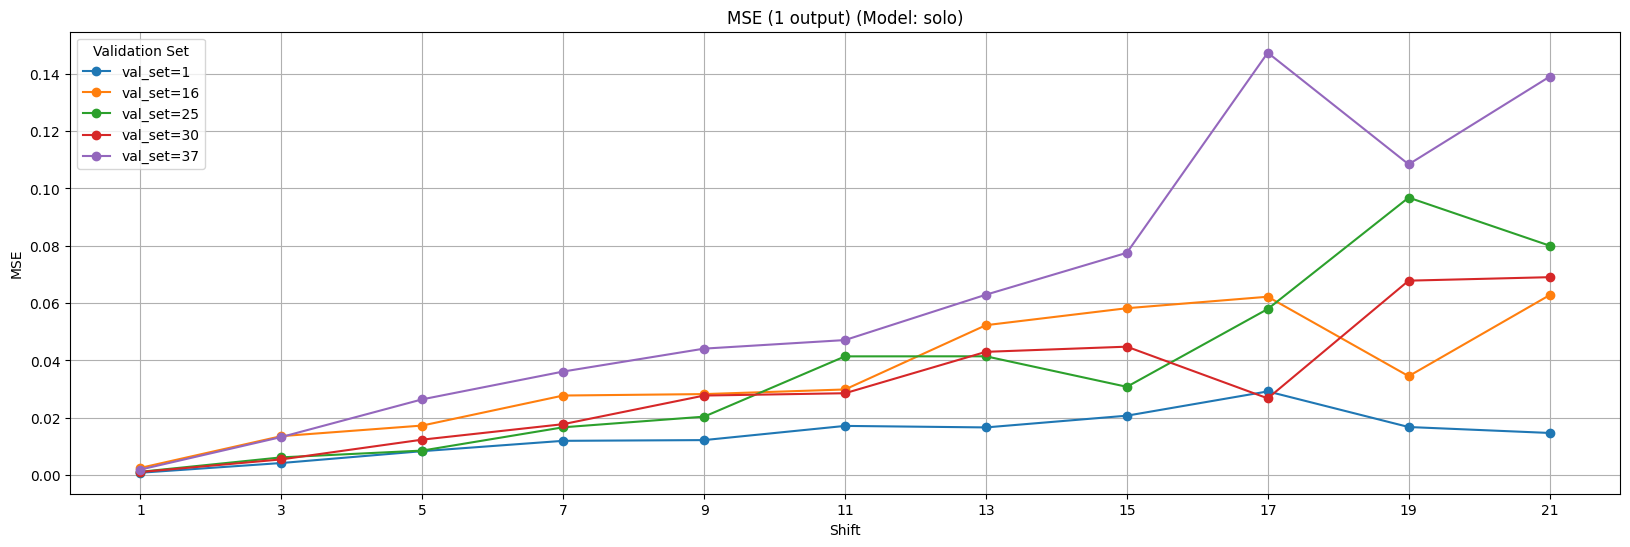

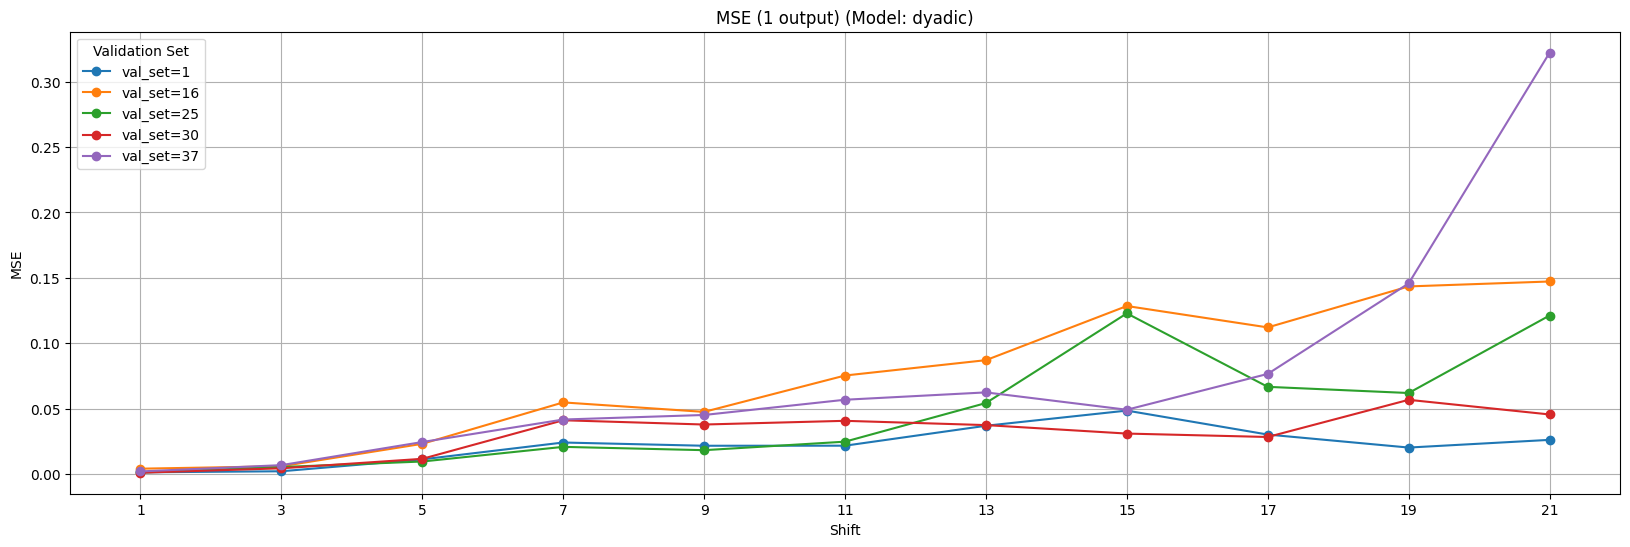

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results from the CSV file
df = pd.read_csv('results_1var_5bs.csv')

# Define the specific x-axis ticks you want
x_ticks = np.arange(1, 23,2)

# Get unique values for val_set and model_type
val_sets = df["val_set"].unique()
models = df["model_type"].unique()

# Plot for each model
for model in models:
    plt.figure(figsize=(20, 6))
    
    # Subset dataframe for the current model
    model_df = df[df["model_type"] == model]
    
    # Plot each val_set on the same figure
    for val_set in val_sets:
        subset_df = model_df[model_df["val_set"] == val_set]
        
        # Plot MSE values for the current val_set with respect to "shift"
        plt.plot(subset_df["shift"], subset_df["mse"], marker='o', label=f"val_set={val_set}")

    # Labels, title, legend, and grid
    plt.xlabel("Shift")
    plt.ylabel("MSE")
    plt.title(f"MSE (1 output) (Model: {model})")
    plt.legend(title="Validation Set")
    plt.grid(True)
    
    # Set specific x-axis ticks
    plt.xticks(x_ticks)
    
    # Display the plot
    plt.show()


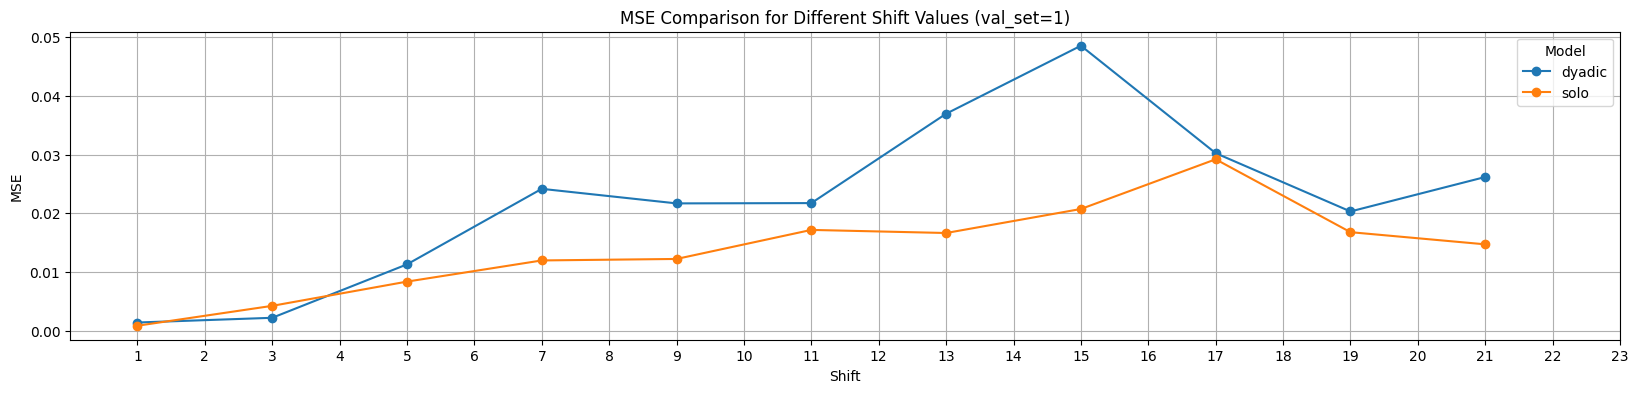

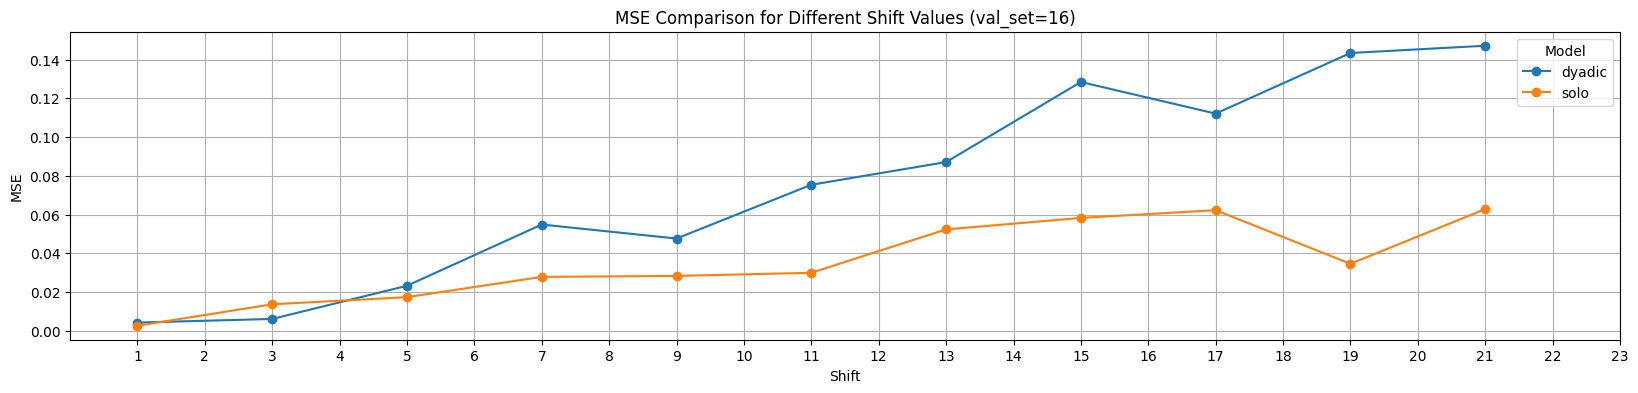

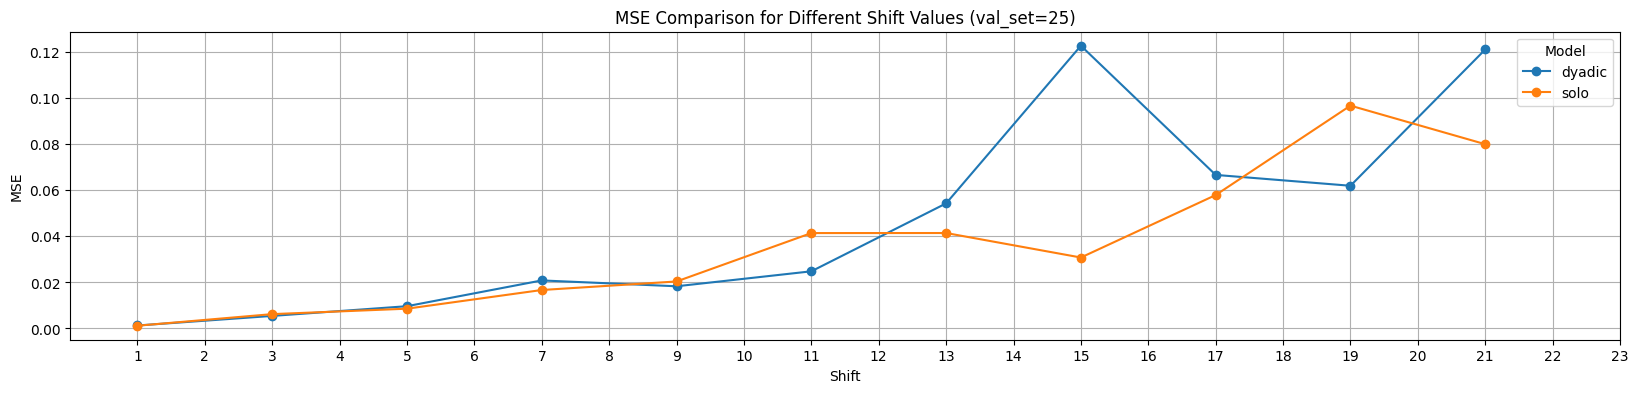

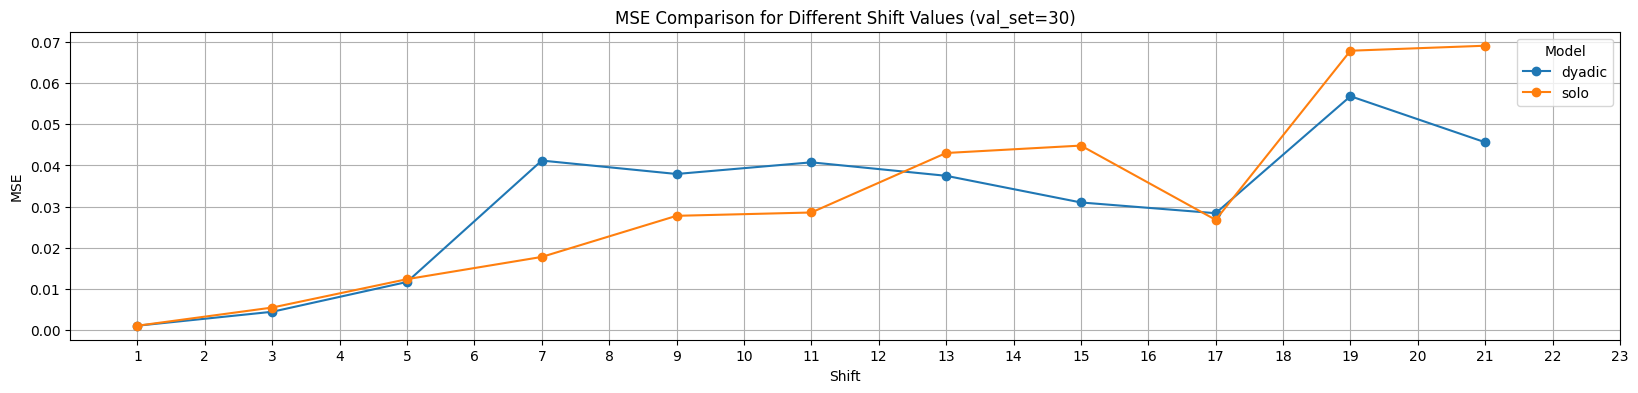

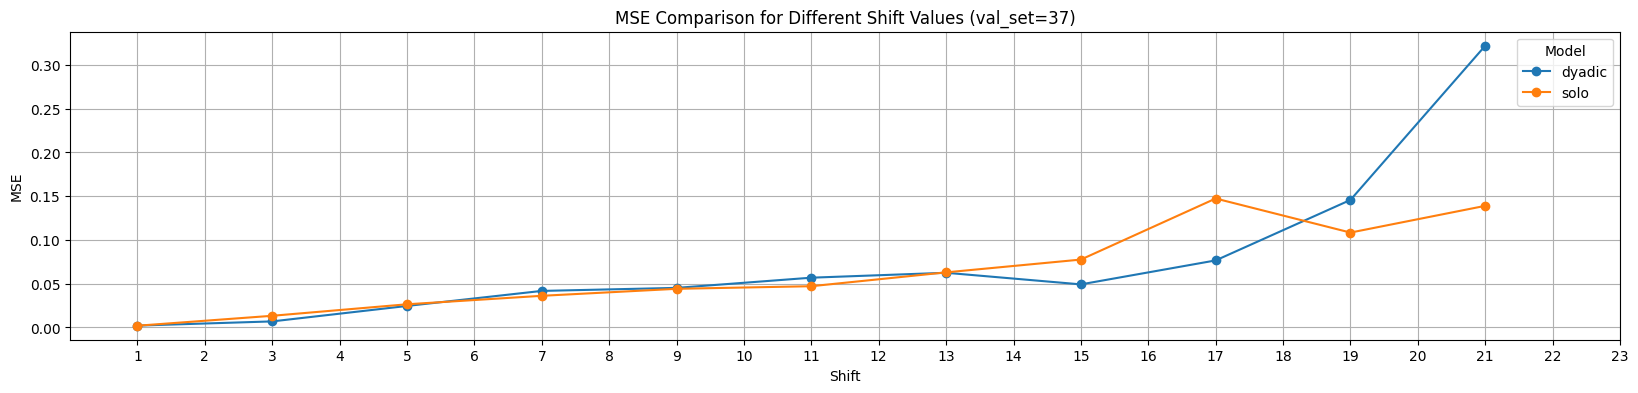

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results from the CSV file
df = pd.read_csv('results_1var_5bs.csv')

# Get unique val_set values
val_sets = df["val_set"].unique()
x_ticks = np.arange(1, 24)

# Plot for each val_set
for val_set in val_sets:
    subset_df = df[df["val_set"] == val_set]
    pivot_df = subset_df.pivot(index="shift", columns="model_type", values="mse")

    plt.figure(figsize=(20, 4))
    for model in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[model], marker='o', label=model)
        
    # Labels and title
    plt.xticks(x_ticks)
    plt.xlabel("Shift")
    plt.ylabel("MSE")
    plt.title(f"MSE Comparison for Different Shift Values (val_set={val_set})")
    plt.legend(title="Model")
    plt.grid(True)
    plt.show()


In [23]:
class ExperimentEncoder_LN(nn.Module):
    def __init__(self, input_size=12, hidden_size=32, num_layers=1, device=None):
        super().__init__()
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bias=False)
        
        # Initialize the hidden state for GRU
        self.initial_hidden_state = nn.Parameter(torch.zeros(1, 1, hidden_size))  # unidirectional GRU
        
        # Add layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.device = device
        
    def forward(self, input_):
        # Input should be a PackedSequence
        if not isinstance(input_, PackedSequence):
            raise ValueError('Input must be a PackedSequence.')
        
        batch_size = input_.unsorted_indices.shape[0]  # Extract batch size from PackedSequence
        initial_hidden_state = self.initial_hidden_state.repeat(1, batch_size, 1)
        
        # Forward pass through GRU
        factors, _ = self.gru(input_, initial_hidden_state)
        
        # Return unpacked sequence
        factors = unpack_sequence(factors)
        factors[0] = self.layer_norm(factors[0])
        
        return factors

In [ ]:
hidden_values = [16]

lag_values = np.arange(1,23,2)
set_value = [1,16,25,30,37]
drop_trials = [4,7,21,46,47,48,54,58,17,8]

models = ['solo']

# Some Code
for m in models:
    for h in hidden_values:
        for s in lag_values:
            for v in set_value:
                model_type = m
                val = [v]

                hidden_size= 16
                n_epochs = 2000

                shift = s
                model_name = str(model_type)+'_h'+str(hidden_size)+'_e'+str(n_epochs)+'_v'+str(set_value)+'_s'+str(shift)
                labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
                if model_type == 'dyadic':
                    columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4','oDistReach_1','oDistReach_2','oDistReach_3','oDistReach_4']
                else:
                    columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']


                lag_word = '_lagged'
                input_size = len(columns_to_shift)
                output_size = len(labels)

                core = ExperimentEncoder_LN(input_size,hidden_size, num_layers=1)
                readout = NonlinearDecoder(hidden_size, output_size)
                model = CoreAndReadout(core, readout)
                model = model.to(device)

                loss = nn.MSELoss() 
                loss_fn = M2S_Loss3(loss)
                data = "C:/Users/kacpe/Desktop/lab_rotation_git/forKacper/datasets/combined_dataset.csv"

                df = pd.read_csv(data)
                
                df = df[~df['trial'].isin(drop_trials)]
        
                                                # Function to bin within each trial
        
        
                    # Apply binning within each 'trial' group
                df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
                df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                shifted_df = pd.DataFrame()
        
        
                # Loop through unique trial values
                for trial_value in df['trial'].unique():
                    # Filter the DataFrame for the current trial
                    trial_df = df[df['trial'] == trial_value].copy()
        
                    # Create shifted columns for each column in columns_to_shift
                    for col in columns_to_shift:
                        new_col_name = col + lag_word
                        trial_df[new_col_name] = trial_df[col].shift(-shift)
        
        
                    # Drop the last 'i' records for each trial
                    trial_df = trial_df.dropna()
        
        
        
                    # Append the modified trial_df to the shifted_df
                    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)
               
                features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]
                
                batch_size = len(shifted_df['trial'].unique()) - len(set_value)

                val_set = shifted_df[shifted_df['trial'].isin(val)]
                val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
                val_dataloader = DataLoader(val_dataset, batch_size=len(val), shuffle=False, collate_fn=collate_packed_sequences)

                os.chdir(f'C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/1111_fixedLog/{model_type}_4var/models')
               # model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))



                with torch.no_grad():
                    for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                        # Move inputs and outputs to the appropriate device
                        inputs = inputs.to(device)
                        outputs = [output.to(device) for output in outputs]  # Ensure all outputs are on the same device

                        # Get model predictions for the current batch
                        y_pred_batch = model(inputs)  # Predictions for the entire batch

                        # Iterate through each trial in the batch
                        for i in np.arange(len(y_pred_batch)):
                            prediction = y_pred_batch[i]  # Get the prediction for the current trial

                            # Convert the prediction and true values to numpy for plotting
                            prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy for plotting
                            true_value_np = outputs[i].detach().cpu().numpy()  # True values for the current trial

                                        # Now that both y_pred and y_true are collected, calculate R²
                            r2_h = r2_score(true_value_np, prediction_np)
                            mse_h = loss_fn(y_pred_batch,outputs)


                            print(f'{model_type}_R2_{shift}_{val[0]}_{hidden_size}_{r2_h}')

                            print(f'{model_type}_MSE_{shift}_{val[0]}_{hidden_size}_{mse_h}')

solo_R2_1_1_16_-4.215780812666256
solo_MSE_1_1_16_1.6421154737472534
solo_R2_1_16_16_-18.58562986316706
solo_MSE_1_16_16_2.8680989742279053
solo_R2_1_25_16_-9.686605933785682
solo_MSE_1_25_16_1.6582573652267456
solo_R2_1_30_16_-7.315174574304084
solo_MSE_1_30_16_2.569976806640625
solo_R2_1_37_16_-11.323762582359532
solo_MSE_1_37_16_3.2143609523773193
solo_R2_2_1_16_-6.671785063624915
solo_MSE_2_1_16_1.6443533897399902
solo_R2_2_16_16_-24.193753252980468
solo_MSE_2_16_16_3.4041011333465576
solo_R2_2_25_16_-14.985184047472941
solo_MSE_2_25_16_3.1435818672180176
solo_R2_2_30_16_-37.76509348361262
solo_MSE_2_30_16_3.652813196182251
solo_R2_2_37_16_-8.807421115516759
solo_MSE_2_37_16_2.6035571098327637
solo_R2_3_1_16_-16.88548523918605
solo_MSE_3_1_16_1.6816833019256592
solo_R2_3_16_16_-6.881022837494335
solo_MSE_3_16_16_1.7966398000717163
solo_R2_3_25_16_-10.983348510862061
solo_MSE_3_25_16_2.1590707302093506
solo_R2_3_30_16_-5.867232137549124
solo_MSE_3_30_16_2.182743549346924
solo_R2_3_3

In [25]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drop_trials = [4,7,21,46,47,48,54,58,17,8,52,56,17]
# Initialize a list to store all results
all_results = []
folds = [1,16,25,30,37]
models = ['solo','dyadic']
lag_values = np.arange(1,23,2)
for m in models:
    for s in lag_values:
        for f in folds:
            model_type = m
            set_value = [f]
        
            hidden_size = 16
            n_epochs = 2000
            shift = s
            model_name = f'{model_type}_h{hidden_size}_e{n_epochs}_v{folds}_s{shift}'
            labels = ['aDistReach_3']
            if model_type == 'dyadic':
                columns_to_shift = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4', 'oDistReach_1', 'oDistReach_2', 'oDistReach_3', 'oDistReach_4']
            else:
                columns_to_shift = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4']

            lag_word = '_lagged'
            input_size = len(columns_to_shift)
            output_size = len(labels)

            core = ExperimentEncoder_LN(input_size, hidden_size, num_layers=1)
            readout = NonlinearDecoder(hidden_size, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss3(loss)
            data = "C:/Users/kacpe/Desktop/lab_rotation_git/forKacper/datasets/combined_dataset.csv"

            df = pd.read_csv(data)
            df = df[~df['trial'].isin(drop_trials)]

            # Function to bin within each trial
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                trial_df = df[df['trial'] == trial_value].copy()
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                trial_df = trial_df.dropna()
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

            features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]
            batch_size = len(shifted_df['trial'].unique()) - len(set_value)

            val_set = shifted_df[shifted_df['trial'].isin(set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=len(set_value), shuffle=False, collate_fn=collate_packed_sequences)

            # Load the trained model
            model_path = f'C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/1111_fixedLog/5batch/{model_type}_1var/models/{model_name}_best_model.pth'
            model.load_state_dict(torch.load(model_path, map_location=device))

            # Evaluation
            model.eval()
            results = []

            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]
                    y_pred_batch = model(inputs)
                    
                    for i in range(len(y_pred_batch)):
                        prediction = y_pred_batch[i]
                        prediction_np = prediction.detach().cpu().numpy()
                        true_value_np = outputs[i].detach().cpu().numpy()
                        r2_h = r2_score(true_value_np, prediction_np)
                        mse_h = loss_fn(y_pred_batch, outputs)
                        
                        results.append({
                            'model_type': model_type,
                            'shift': shift,
                            'val': set_value,
                            'hidden_size': hidden_size,
                            'r2': r2_h,
                            'mse': mse_h.item()
                        })

            # Append the results for this model to the all_results list
            all_results.extend(results)

# Save all results to a single CSV file
os.chdir('C:\\Users\\kacpe\\Desktop\\lab_rotation_git\\')
all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv('results_1var_5bs.csv', index=False)

print("Evaluation complete. All results saved to all_evaluation_results.csv")


Evaluation complete. All results saved to all_evaluation_results.csv


In [ ]:
os.getcwd()

'C:\\Users\\kacpe\\Desktop\\lab_rotation_git\\packed_plots\\1111_fixedLog\\solo_4var\\models'

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader

# Your existing data processing, model, and custom loss imports here

# Model Evaluation Loop
for m in models:
    for h in hidden_values:
        for s in lag_values:
            for v in set_value:
                # Model and parameter configuration
                model_type = m
                val = [v]
                hidden_size = 16
                n_epochs = 2000
                shift = s
                model_name = f"{model_type}_h{hidden_size}_e{n_epochs}_v{set_value}_s{shift}"
                
                # Define labels and columns based on model type
                labels = ['aDistReach_1', 'aDistReach_2', 'aDistReach_3', 'aDistReach_4']
                columns_to_shift = labels + (['oDistReach_1', 'oDistReach_2', 'oDistReach_3', 'oDistReach_4'] if model_type == 'dyadic' else [])
                lag_word = '_lagged'
                input_size = len(columns_to_shift)
                output_size = len(labels)

                # Model Initialization
                core = ExperimentEncoder_LN(input_size, hidden_size, num_layers=1)
                readout = NonlinearDecoder(hidden_size, output_size)
                model = CoreAndReadout(core, readout).to(device)

                # Try loading the model
                try:
                    model.load_state_dict(torch.load(f"{model_name}_best_model.pth", map_location=torch.device('cpu')))
                    model.eval()  # Set the model to evaluation mode
                    print(f"Loaded model {model_name} successfully.")
                except FileNotFoundError:
                    print(f"Model file {model_name} not found. Skipping this configuration.")
                    continue

                # Data Loading
                data = "C:/Users/kacpe/Desktop/lab_rotation_git/forKacper/datasets/combined_dataset.csv"
                df = pd.read_csv(data)
                df = df[~df['trial'].isin(drop_trials)]
                df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
                df[columns_to_shift] = df[columns_to_shift].apply(np.log)

                # Apply shift and create shifted dataset
                shifted_df = pd.DataFrame()
                for trial_value in df['trial'].unique():
                    trial_df = df[df['trial'] == trial_value].copy()
                    for col in columns_to_shift:
                        trial_df[f"{col}{lag_word}"] = trial_df[col].shift(-shift)
                    trial_df = trial_df.dropna()
                    shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

                # Dataset Splitting
                features = shifted_df.columns[shifted_df.columns.str.contains(lag_word)]
                train_set = shifted_df[~shifted_df['trial'].isin(val)]
                val_set = shifted_df[shifted_df['trial'].isin(val)]

                # DataLoader Setup
                batch_size = max(1, len(train_set['trial'].unique()) - len(set_value))  # Avoid 0 batch size if len(set_value) == len(train_set)
                train_dataset = TrialDataset_seq(train_set, X=features, y=labels, seq_len=1)
                val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
                train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_packed_sequences)
                val_dataloader = DataLoader(val_dataset, batch_size=len(val), shuffle=False, collate_fn=collate_packed_sequences)

                # Metric Calculation for Validation Set
                with torch.no_grad():
                    all_predictions = []
                    all_true_values = []
                    for inputs, outputs in val_dataloader:
                        inputs, outputs = inputs.to(device), [out.to(device) for out in outputs]
                        y_pred_batch = model(inputs)
                        all_predictions.extend(y_pred_batch.detach().cpu().numpy())
                        all_true_values.extend([out.detach().cpu().numpy() for out in outputs])

                    # Convert lists to arrays for metric calculation
                    all_predictions = np.array(all_predictions)
                    all_true_values = np.array(all_true_values)

                    # Calculate R2 and MSE metrics
                    r2_h = r2_score(all_true_values, all_predictions)
                    mse_h = loss_fn(torch.tensor(all_predictions), torch.tensor(all_true_values))

                    print(f"{model_type}_R2 (shift={shift}, val={val[0]}, hidden={hidden_size}): {r2_h}")
                    print(f"{model_type}_MSE (shift={shift}, val={val[0]}, hidden={hidden_size}): {mse_h}")


Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s1 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s1 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s1 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s1 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s1 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s2 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s2 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s2 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s2 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s2 not found. Skipping this configuration.
Model file solo_h16_e2000_v[1, 16, 25, 30, 37]_s3 not found. Skipping this configuration.
Model file

AttributeError: 'list' object has no attribute 'detach'

# PCA

In [ ]:
hidden_values = [20, 24]
epoch_values = [2000]
val_values = [1,16,25,30,37]
lag_values = [3,6,9,12,15]
from sklearn.decomposition import PCA
data = "C:/Users/kacpe/Desktop/lab_rotation_git/forKacper/datasets/combined_dataset.csv"
#val_values = [x for x in range(1, 62) if x not in [4,6,7,21,22,46,47,48,50,54,58]]

# Some Code

for h in hidden_values:
    for s in lag_values:
        for v in val_values:
            
            hidden_size_m = 16
            n_epochs = 2000  
            set_value = v
            shift = s
           # solo_h20_e2000_v[1, 16, 25, 30, 37]_s6_best_model.pth
           # solo_h20_e2000_v1_s3_best_model.pth
            model_name = 'solo'+'_h'+str(hidden_size_m)+'_e'+str(n_epochs)+'_v[1, 16, 25, 30, 37]'+'_s'+str(shift)
            labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            lag_word = '_lagged'
            input_size = 2
            output_size = len(labels)

            core = ExperimentEncoder(input_size,hidden_size_m, num_layers=1)
            readout = NonlinearDecoder(hidden_size_m, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = None #ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
            loss = nn.MSELoss()
            loss_fn = M2S_Loss3(loss)
            
            df = pd.read_csv(data)
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                            # Function to bin within each trial


                # Apply binning within each 'trial' group
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            


            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


            # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

                                    # Define lagged monkey and human distance columns
            monkey_lagged_columns = [col + lag_word for col in columns_to_shift if col.startswith('a')]
        
                
            # Apply PCA to the shifted (lagged) columns for monkey and human distances with 2 components each
            pca_monkey = PCA(n_components=2)
        

            # Fit and transform the monkey and human lagged features
            monkey_pca_components = pca_monkey.fit_transform(shifted_df[monkey_lagged_columns])
       

            # Add each component as a separate column in the DataFrame
            shifted_df['monkey_pca_1'] = monkey_pca_components[:, 0]
            shifted_df['monkey_pca_2'] = monkey_pca_components[:, 1]
        

            # Drop only the original lagged columns (ending with '_lagged')
        
            shifted_df = shifted_df.drop(columns=monkey_lagged_columns)

            # Update features list to include the new PCA component columns
            
            features = ['monkey_pca_1', 'monkey_pca_2']





            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
            os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/0211_PCA/solo_PCA_h24')
            model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))
           # epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
           # yPred_val_m = yPred_val_m[0].squeeze(0).squeeze(-1).cpu().numpy()
                   # Loop through each batch in the validation dataloader
            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    # Move inputs and outputs to the appropriate device
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]  # Ensure all outputs are on the same device

                    # Get model predictions for the current batch
                    y_pred_batch = model(inputs)  # Predictions for the entire batch

                    # Iterate through each trial in the batch
                    for i in np.arange(len(y_pred_batch)):
                        prediction = y_pred_batch[i]  # Get the prediction for the current trial

                        # Convert the prediction and true values to numpy for plotting
                        prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy for plotting
                        true_value_np = outputs[i].detach().cpu().numpy()  # True values for the current trial 
            
            


            
                    # Now that both y_pred and y_true are collected, calculate R²
                    mse_m = loss_fn(y_pred_batch,outputs)
                    r2_m = r2_score(true_value_np, prediction_np)
            hidden_size_h = 16
            model_name = 'dyadic'+'_h'+str(hidden_size_h)+'_e'+str(n_epochs)+'_v[1, 16, 25, 30, 37]'+'_s'+str(shift)
            labels = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4']
            columns_to_shift = ['aDistReach_1','aDistReach_2','aDistReach_3','aDistReach_4','oDistReach_1','oDistReach_2','oDistReach_3','oDistReach_4']
            lag_word = '_lagged'
            input_size = 4
            output_size = len(labels)
            
            core = ExperimentEncoder(input_size,hidden_size_h, num_layers=1)
            readout = NonlinearDecoder(hidden_size_h, output_size)
            model = CoreAndReadout(core, readout)
            model = model.to(device)
            
            df = pd.read_csv(data)
            
            #df[labels] = df[labels].apply(np.log)
            df[columns_to_shift] = df[columns_to_shift].apply(np.log)
                                            # Function to bin within each trial


                # Apply binning within each 'trial' group
            df = df.groupby('trial', group_keys=False).apply(bin_trial_data)
            


            #save_dir = '/kaggle/working/plots/Linear_DecoderHuman'
            #os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
            #shifted_df = shift_dataframe(df,shift,columns_to_shift)
            # Create an empty DataFrame to store the shifted data
            shifted_df = pd.DataFrame()

            # Loop through unique trial values
            for trial_value in df['trial'].unique():
                # Filter the DataFrame for the current trial
                trial_df = df[df['trial'] == trial_value].copy()

                # Create shifted columns for each column in columns_to_shift
                for col in columns_to_shift:
                    new_col_name = col + lag_word
                    trial_df[new_col_name] = trial_df[col].shift(-shift)
                    

                # Drop the last 'i' records for each trial
                trial_df = trial_df.dropna()
                


            # Append the modified trial_df to the shifted_df
                shifted_df = pd.concat([shifted_df, trial_df], ignore_index=True)

                                    # Define lagged monkey and human distance columns
            monkey_lagged_columns = [col + lag_word for col in columns_to_shift if col.startswith('a')]
            human_lagged_columns = [col + lag_word for col in columns_to_shift if col.startswith('o')]
                
            # Apply PCA to the shifted (lagged) columns for monkey and human distances with 2 components each
            pca_monkey = PCA(n_components=2)
            pca_human = PCA(n_components=2)
            #print(df[monkey_lagged_columns])
            # Fit and transform the monkey and human lagged features
            monkey_pca_components = pca_monkey.fit_transform(shifted_df[monkey_lagged_columns])
            human_pca_components = pca_human.fit_transform(shifted_df[human_lagged_columns])

            # Add each component as a separate column in the DataFrame
            shifted_df['monkey_pca_1'] = monkey_pca_components[:, 0]
            shifted_df['monkey_pca_2'] = monkey_pca_components[:, 1]
            shifted_df['human_pca_1'] = human_pca_components[:, 0]
            shifted_df['human_pca_2'] = human_pca_components[:, 1]

            # Drop only the original lagged columns (ending with '_lagged')
            shifted_df = shifted_df.drop(columns=monkey_lagged_columns + human_lagged_columns)
            

            # Update features list to include the new PCA component columns
            features = ['monkey_pca_1', 'monkey_pca_2', 'human_pca_1', 'human_pca_2']
            
            




            val_set = shifted_df[(shifted_df['trial'] == set_value)]
            val_dataset = TrialDataset_seq(val_set, X=features, y=labels, seq_len=1)
            val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_packed_sequences)
            os.chdir('C:/Users/kacpe/Desktop/lab_rotation_git/packed_plots/0211_PCA/dyadic_PCA_h24')
            model.load_state_dict(torch.load(f'{model_name}_best_model.pth',map_location=torch.device('cpu')))
           # epoch_val_loss_m, yPred_val_m = validate(val_dataloader, model, loss_fn, device=None)
           # yPred_val_m = yPred_val_m[0].squeeze(0).squeeze(-1).cpu().numpy()
                   # Loop through each batch in the validation dataloader
            with torch.no_grad():
                for batch_idx, (inputs, outputs) in enumerate(val_dataloader):
                    # Move inputs and outputs to the appropriate device
                    inputs = inputs.to(device)
                    outputs = [output.to(device) for output in outputs]  # Ensure all outputs are on the same device

                    # Get model predictions for the current batch
                    y_pred_batch = model(inputs)  # Predictions for the entire batch

                    # Iterate through each trial in the batch
                    for i in np.arange(len(y_pred_batch)):
                        prediction = y_pred_batch[i]  # Get the prediction for the current trial

                        # Convert the prediction and true values to numpy for plotting
                        prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy for plotting
                        true_value_np = outputs[i].detach().cpu().numpy()  # True values for the current trial
                        
                        # Now that both y_pred and y_true are collected, calculate R²
            r2_h = r2_score(true_value_np, prediction_np)
            mse_h = loss_fn(y_pred_batch,outputs)
            
            print(f'solo_R2_{shift}_{set_value}_{hidden_size_m}_{r2_m}')
            print(f'dyadic_R2_{shift}_{set_value}_{hidden_size_h}_{r2_h}')
            print(f'solo_MSE_{shift}_{set_value}_{hidden_size_m}_{mse_m}')
            print(f'dyadic_MSE_{shift}_{set_value}_{hidden_size_h}_{mse_h}')
            

FileNotFoundError: [Errno 2] No such file or directory: 'solo_h16_e2000_v[1, 16, 25, 30, 37]_s3_best_model.pth'